# DATA 612 Project 2 - Joke Recommender System Part II

By Mike Silva

## Introduction

This is the continuation of the creation of a recommender system that provides users with jokes that they will find funny.  By providing this content we will keep users engaged longer on the website.

### About the Jester Dataset

For this project I will be using the [Jester dataset](http://eigentaste.berkeley.edu/dataset/).  It was created by Ken Goldberg at UC Berkley (Eigentaste: A Constant Time Collaborative Filtering Algorithm. Ken Goldberg, Theresa Roeder, Dhruv Gupta, and Chris Perkins. Information Retrieval, 4(2), 133-151. July 2001).

Data files are in .zip format, when unzipped, they are in Excel (.xls) format.  The ratings are real values ranging from -10.00 to +10.00 (the value "99" corresponds to "null" meaning "not rated").  Each row is a user.  The first column gives the number of jokes rated by the user. The next 100 give the ratings for jokes 1 to 100.  I will only be the first data set that has data for users that have rated 36 or more jokes.  

In addition to the ratings, we will be using the actual joke content.  It is also available through the website in a .zip file.  Each joke is in an HTML file.  There are comments in the HTML that indicate where the joke begins and where it ends.  I will note that some of the text in the HTML files is poorly done.  There are cases where there aren't spaces after punctuation marks and they didn't follow HTML standards.  There will be some cleanup of the text of the jokes.

### data612

This notebook relies on the module I created for this class.  You can see the [data612 module here](https://github.com/mikeasilva/CUNY-SPS/blob/master/DATA612/data612.py).

## Data Acquisition

We will begin by loading the libraries we need and acquiring the data.  As I previously noted, the ratings were previously downloaded in Part I; but I include the code in case someone starts from this juncture.  Let's download the joke text and the ratings.

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import requests
import scipy.cluster.hierarchy as hclust
import seaborn as sns
from shutil import rmtree
from sklearn.preprocessing import normalize
import zipfile
# Import my custom module for this class
import data612

%matplotlib inline

# STEP 1 - DOWNLOAD THE DATA SET
if not os.path.exists("jester_dataset_1_joke_texts.zip"):
    # We need to download it
    response = requests.get("http://eigentaste.berkeley.edu/dataset/jester_dataset_1_joke_texts.zip")
    if response.status_code == 200:
        with open("jester_dataset_1_joke_texts.zip", "wb") as f:
            f.write(response.content)
## This was done in Part I but we will include this just in case
if not os.path.exists("jester_dataset_1_1.zip"):
    # We need to download it
    response = requests.get("http://eigentaste.berkeley.edu/dataset/jester_dataset_1_1.zip")
    if response.status_code == 200:
        with open("jester_dataset_1_1.zip", "wb") as f:
            f.write(response.content)
# STEP 2 - EXTRACT ALL FILES
if not os.path.exists("jokes"):
    with zipfile.ZipFile("jester_dataset_1_joke_texts.zip","r") as z:
        z.extractall()
    # CLEANUP
    rmtree("__MACOSX")
## Again this was done in Part I but we are including this just in case
if not os.path.exists("jester-data-1.xls"):
    with zipfile.ZipFile("jester_dataset_1_1.zip","r") as z:
        z.extract("jester-data-1.xls")

We will also use the training and test set generated in Part I for modeling and evaluation in Part II.

In [2]:
if not os.path.exists("project_1_train_df.csv") or not os.path.exists("project_1_test_df.csv"):
    df = pd.read_excel("jester-data-1.xls",  header=None, na_values = 99)
    df = df.drop([0], axis=1)
    train_df, test_df = data612.train_test_split(df)
    train_df.to_csv("project_1_train_df.csv", index = False)
    test_df.to_csv("project_1_test_df.csv", index = False)
else:
    train_df = pd.read_csv("project_1_train_df.csv")
    test_df = pd.read_csv("project_1_test_df.csv")


## Content-Based Filtering

In this section I will develop a content-based filtering.  The recommender system will recommend jokes based on similar content.  Now that the jokes have been downloaded we need to read in the joke text into a list for processing:

In [3]:
jokes = list()

for n in range(1, 101):
    joke_text = data612.read_joke(n)
    jokes.append(joke_text)

### TF-IDF

Now that I have the content of the jokes I will preprocess the text.  I will remove the numbers and expand all contractions.  Then compute the TF-IDF.  We will use the cosine similarity of the TF-IDF to find similar jokes on the basis of the joke's text.

In [4]:
preprocessed_jokes = data612.preprocess_jokes(jokes, remove_numbers=True, remove_contractions=True)
tfidf_df = data612.tf_idf(preprocessed_jokes)
cosine_similarity_df = data612.cosine_similarity(tfidf_df)

Now that we have that let's visualize the results:

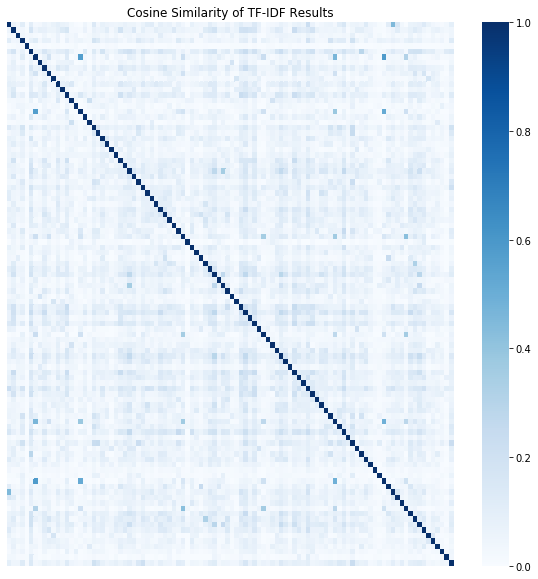

In [5]:
plt.figure(figsize=(10, 10))
plt.title("Cosine Similarity of TF-IDF Results") 
sns.heatmap(cosine_similarity_df, cmap="Blues", xticklabels=False, yticklabels=False)
plt.ylabel('')
plt.xlabel('')
plt.show()

This visualization suggests that TF-IDF is not very effective on the conent of the jokes. Let's see how well this preforms.  Based on the preceeding visualization I'm not expecting very good recommendations. Let's try it out on the first joke:

In [6]:
print(data612.read_joke(1))

A man visits the doctor. The doctor says "I have bad news for you.You have cancer and Alzheimer's disease". The man replies "Well,thank God I don't have cancer!"


Let's generate some recommendations and see how this approach preforms.  We will pick the 5 closest matches based on their cosine similarity to joke number 1.  They will be ordered in the closest match (or best recommendation) to the farthest match (worst recommendation).

In [7]:
content_recommendations = data612.get_cosine_based_joke_recommendations(cosine_similarity_df, joke_id = 1, n_recommendations = 5)
content_recommendations

[87, 68, 88, 76, 20]

In [8]:
print(data612.read_joke(content_recommendations[0]))

A man, recently completing a routine physical examination receives a phone call from his doctor. The doctor says, "I have some good news and some bad news." The man says, "OK, give me the good news first." The doctor says, "The good news is, you have 24 hours to live." The man replies, "Shit! That's the good news? Then what's the bad news?" The doctor says, "The bad news is, I forgot to call you yesterday."


That one was suprisingly similar.  They both were doctor patient jokes.  If you found joke number to be funny, this isn't a bad content based recommendation.  Perhaps I was too hard on the model.  Let's see the next recommendation.

In [9]:
print(data612.read_joke(content_recommendations[1]))

A man piloting a hot air balloon discovers he has wandered off course and is hopelessly lost. He descends to a lower altitude and locates a man down on the ground. He lowers the balloon further and shouts "Excuse me, can you tell me where I am?" The man below says: "Yes, you're in a hot air balloon, about 30 feet above this field." "You must work in Information Technology," says the balloonist. "Yes I do," replies the man. "And how did you know that?" "Well," says the balloonist, "what you told me is technically correct, but of no use to anyone." The man below says, "You must work in management." "I do," replies the balloonist, "how did you know?" "Well," says the man, "you don't know where you are, or where you're going, but you expect my immediate help. You're in the same position you were before we met, but now it's my fault!"


That one had nothing to do with the first one.  I guess my first sentiment was right on.

In [10]:
print(data612.read_joke(content_recommendations[2]))

A Czechoslovakian man felt his eyesight was growing steadily worse, and felt it was time to go see an optometrist. The doctor started with some simple testing, and showed him a standard eye chart with letters of diminishing size: CRKBNWXSKZY. . . "Can you read this?" the doctor asked. "Read it?" the Czech answered. "Doc, I know him!"


It is another doctor patient joke, but the fact that it is in this order indicates the is more work to do to get this to work right.

In [11]:
print(data612.read_joke(content_recommendations[3]))

There once was a man and a woman that both got in a terrible car wreck. Both of their vehicles were completely destroyed, buy fortunately, no one was hurt. In thankfulness, the woman said to the man, 'We are both okay, so we should celebrate. I have a bottle of wine in my car, let's open it.' So the woman got the bottleout of the car, and handed it to the man. The man took a really big drink, and handed the woman the bottle. The woman closed the bottle and put it down. The man asked, 'Aren't you going to take a drink?' The woman cleverly replied, 'No, I think I'll just wait for the cops to get here.'


Ah!  It seems the second and this last joke were recommended because they were both about a "man."  If you find this joke about a man funny perhaps you will find this other joke about a man funny.  I guess there may be some people that could share that kind of thinking, but I personally find the recommendations to be poor.  Let's take a look at the last recommendation.

In [12]:
print(data612.read_joke(content_recommendations[4]))

What's the difference between a MacIntosh and an Etch-A-Sketch? You don't have to shake the Mac to clear the screen.


I am not sure why this joke was recommended based off of the first joke.  I don't see any strong similarity.  I would personally call this a poor recommendation.  But that is my opinion.  Let's test this against some data.

### Evaluation Technique

In evaluating these recommendations we will say a recommendation can either be a "good" recommendation or a "bad" recommendation.  The point of this recommendation system is to provided content to the user that they will like.  The joke ratings range from -10 to 10.  We will say that any joke with a 5 or higher is content that the user likes.  Everything else they dislike.

We will evaluate the content based recommendations by identifying those records where people "liked" joke number 1.  We will look at if they liked or disliked the recommended joke.  We will measure the percent of the time our prediction was accurate.  We will load in all the jokes, and see how the recommendation engine preformed.

In [13]:
df = pd.read_excel("jester-data-1.xls",  header=None, na_values = 99)
df = df.drop([0], axis=1)

In [14]:
def evaluate_content_recommendations(df, recommendations, like_threshold):
    """Detrmine the share of joke recommendations that are good.
    Args:
        df (DataFrame): The data frame of users that like the joke being evaluated
        recommendations(list): The list of jokes recommended based of of the content
        like_threshold (int): The minimum rating needed to be considered "liked" by a user
    Return:
        results_dict (dict): The joke and the share of users that liked the joke
    """
    # Subset the columns
    df = df[recommendations]
    # Wide to Long
    df = df.stack().reset_index().dropna().drop("level_0", axis=1)
    # Create good recommendation label
    df["good_recommendation"] = df[0].apply(lambda x: "Yes" if x >= like_threshold else "No")
    # Get the counts by the label
    df = df.groupby(["level_1", "good_recommendation"]).count().reset_index()
    # Rename
    df.columns = ["level_1", "good_recommendation", "value"]
    # Get the total number of jokes
    totals = df.groupby(["level_1"])["value"].sum().reset_index()
    totals.columns = ["level_1", "total"]
    # Merge in the totals
    df = pd.merge(df, totals)
    # Compute recommendation accuracy
    df["accuracy"] = df["value"] / df["total"]
    # We only care about the share that considered the recommendation good
    df = df[df["good_recommendation"] == "Yes"]
    # Transform the data into a single row data frame
    df = df.pivot(index="good_recommendation", columns="level_1", values="accuracy").reset_index()
    # Reorder the columns
    df = df[recommendations]
    # Convert to dictionary
    results_dict = df.to_dict("r")[0]
    return results_dict

like_threshold = 5
likes_joke_one = df[df[1] >= like_threshold]
evaluate_content_recommendations(likes_joke_one, content_recommendations, like_threshold)

{87: 0.4916488222698073,
 68: 0.4921104536489152,
 88: 0.48713622943905527,
 76: 0.47928994082840237,
 20: 0.20216962524654833}

At best (recommending joke 87) less than half of the users would find it to be a good recommendation.  But that is only one joke.  Let's test it out on all of the jokes:

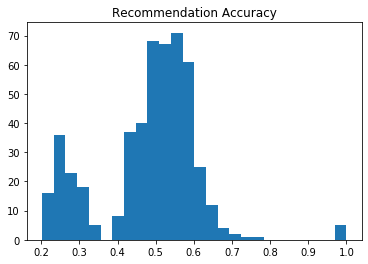

In [15]:
accuracy = []
for j in range(1, 101):
    results = evaluate_content_recommendations(df[df[j] >= like_threshold], content_recommendations, like_threshold) 
    results = list(results.values())
    accuracy.extend(results)
accuracy = np.asarray(accuracy)
plt.hist(accuracy, bins="auto")
plt.title("Recommendation Accuracy")
plt.show()

This model is basically as good as a coin toss, and in some cases much worst!  Based on these results, I would not recommend a content based recommendation strategy for jokes. 

### Why did TF-IDF Preform Poorly?

The reason it preforms is that the TF-IDF really doesn't capture the context of the words.  It is basically a word frequency count algorithm.  It really misses the point of the content.  In short it is the wrong tool for the job.

## Collaborative Filtering

We will try to implement some collaborative filtering on the data set and see how that preforms in comparison to the content based recommendations.

We will load the training and test set developed in Project 1, use the training set to develop the collaborative filter and use it to predict the ratings for the test set and evaluate it.

### User-User Collaborative Filtering

Perhaps a user based recommendation would preform better.  We will try using cosine similarity to find similar users.  In order to compute cosine similarity we will fill all the N/A's with zeros.

In [16]:
full_train = train_df.fillna(0)
# Compute the cosine similarity for the users (this will take some time)
user_cosine_similarity = data612.cosine_similarity(full_train)
np.sum(test_df.count())

362091

The test set is very large (360,000+ ratings).  It would be too costly to evaluate all of these ratings so we will subset the train set and evaluate the model using the subset.

In [17]:
if not os.path.exists("project_2_test_df.csv"):
    unused_df, project_2_test = data612.train_test_split(test_df, train_proportion=0.95)
    project_2_test.to_csv("project_2_test_df.csv", index = False)
else:
    project_2_test = pd.read_csv("project_2_test_df.csv")
np.sum(project_2_test.count())

18105

This is workable.  

### Evaluation Method

In order to evaluate the effectiveness of the collaborative filter, we will look at the ratings in the subset of the test frame and compare it against our predictions.

Since this is a user to user collaborative filter, the predictions will be found by identifying a neighborhood of similar users, getting their rating for the joke in question, and compute a weighted average using the cosine similarity as the weight.

Once we have the predictions we compare it against the actual rating to determine the error.  We will summarize the errors with a histogram so we can see their distribution.

In [18]:
def get_collaborative_filter_errors(cosine_similarity_df, train_df, test_df, n_neighbors=10):
    """Get the errors for the collaborative filter predictions.
    Args:
        cosine_similarity_df (DataFrame): The cosine similarity data to use to find neighbors
        train_df (DataFrame): The rating data
        test_df (DataFrame): The ratings we are going to predict
        n_neighbors (int): The number of neighbors (Optional - 10 default)
    Return:
        errors (list): The prediction errors
    """
    test_df = test_df.stack().reset_index() 
    test_df.columns = ['level_0', 'level_1', 'rating']
    neighbors = dict()
    errors = []
    for i in test_df.index:
        row = test_df.loc[i]
        row_id = row['level_0']
        col_id = row['level_1']
        actual = row['rating']
        # Get the neighbors
        neighbors[i] = neighbors.get(i, data612.get_cosine_based_neighbors(cosine_similarity_df, n_neighbors))
        # Create rating predictions
        try:
            neighbors_ratings = train_df.loc[neighbors[i]][col_id]
            similarity_factor = cosine_similarity_df.loc[neighbors[i]][row_id]
            neighbors_data = neighbors_ratings * similarity_factor
            prediction = neighbors_data.sum() / similarity_factor.sum()
            # Limit the predictions to a -10 to 10 range
            if prediction > 10:
                prediction = 10
            elif prediction < -10:
                prediction = -10
            # Compute the error
            error = prediction - actual
        except:
            error = None
        errors.append(error)
    return errors

user_user_errors = get_collaborative_filter_errors(user_cosine_similarity, train_df, project_2_test)

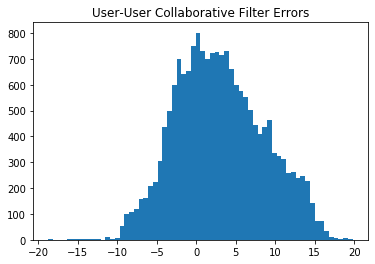

In [19]:
plt.title("User-User Collaborative Filter Errors") 
plt.hist(np.asarray(user_user_errors), bins="auto")
plt.show()

The mean appears to be a little above zero and the distribution is right skewed.  Most of the errors lie in the +/- 5 range which isn't so great given that the ratings are on a scale of ten.  

It appears that using similar users may not be the most effective filter.  Perhaps we will do better with an item based collaborative filter.

### Item-Item Collaborative Filtering

We are going to try to implement an item to item collaborative filter on the dataset.  To do this we need to transpose the training and test set, compute the cosine similarity, and run through the same evaluation as above.

In [20]:
full_train_transposed = full_train.T
test_df_transposed = project_2_test.T
item_cosine_similarity = data612.cosine_similarity(full_train_transposed)
item_item_errors = get_collaborative_filter_errors(item_cosine_similarity, full_train_transposed, test_df_transposed)

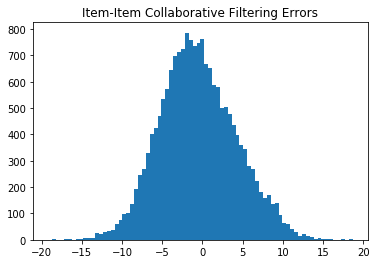

In [21]:
plt.hist(np.asarray(item_item_errors), bins="auto")
plt.title("Item-Item Collaborative Filtering Errors")
plt.show()

The item based collaborative filter is centered around zero and appears to be roughly normal.  There are fewer errors out in the tails than the user to user collaborative filter.  It appears that this is a better filter.  Let's see how it preforms overall

## Comparison of Methods

In order to evaluate the effectiveness of the collaborative filter I will compare the results against the methods developed in the previous project.  We will be looking at the RMSE for the smaller test set predictions.

### Raw Average

We will use the average as a baseline.  

In [22]:
raw_avg = train_df.sum(numeric_only=True).sum() / train_df.count().sum(axis = 0)
data612.get_RMSE(project_2_test, raw_avg)

5.23454752933831

The RMSE is roughly 5.2.  We will compare the other methods against this.

### User and Item Bias Adjusted Baseline

Next we will a baseline adjusted by the user and item bias.

In [23]:
user_bias_train_df, item_bias_train_df = data612.get_biases(project_2_test, raw_avg)
baseline_predictions_df = data612.get_baseline_predictions(raw_avg, user_bias_train_df, item_bias_train_df)
data612.get_RMSE(project_2_test, baseline_predictions_df)

2.761652622530704

This method preformed better than the raw average.  The RMSE is about 2.8.

### User to User Collaborative Filter

Now we will look at the collaborative filters.  We will calculate a RMSE from the prediction errors we have already calculated.

In [24]:
def get_collaborative_filter_RMSE(errors):
    """Calculates the RMSE of collaborative filter errors.
    Args:
        errors (list): A list of the prediction errors
    Returns:
        RMSE (float): The RMSE of the predictions
    """
    squared_errors = np.asarray(errors) ** 2
    mean_squared_errors = np.mean(squared_errors)
    RMSE = mean_squared_errors ** (1 / 2)
    return RMSE

get_collaborative_filter_RMSE(user_user_errors)

6.365233262443108

This is interesting.  The users to user collaborative filter actually preforms worse than using the average.

### Item to Item Collaborative Filter

Let's see how the item to item collaborative filter fared.  I expect it to preform better than the user to user collaborative filter.

In [25]:
get_collaborative_filter_RMSE(item_item_errors)

4.769129496061406

It did.  The RMSE is 4.8 which is better than the average but not as good as the user and item bias adjusted average.

## Summary

In this notebook we developed three filters for a recommender system.  The content based filter did not preform well on this dataset.  We recommend not using this approach when creating recommender system for these jokes.  We then developed collaborative filters and tested them against the baseline methods of project one.  The following table summarizes the results:

| Method                            | RMSE | Comparison to Raw Average |
|-----------------------------------|------|---------------------------|
| Raw Average                       | 5.2  | N/A                       |
| Bias Adjusted Average             | 2.8  | -2.4                      |
| User to User Collaborative Filter | 6.4  | +1.2                      |
| Item to Item Collaborative Filter | 4.8  | -0.4                      |

The item to item collaborative filter preformed better than the user to user collaborative filter.  However both did not out preform the bias adjusted average.  It appears that a collaborative filter is not the best method for generating predictions on the joke dataset.